In [1]:
import os
import sys
import torch
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

repo_path = os.path.abspath("..")
if repo_path not in sys.path:
    sys.path.append(os.path.join(repo_path, "src"))

from model import IVSurfaceMLP, IVSurfaceModelConfig
from train import TrainingConfig, build_dataset_from_df, train
from evaluate import calculate_metrics 
from visualize import plot_market_vs_model_smile

from data_loader import load_raw_data, get_spot_price, prepare_option_data
from preprocessing import clean_data, compute_implied_volatilities, add_additional_features

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BASE_DATE = "2023-01-03"
NEW_DATES = ["2023-01-04", "2023-01-05"]
TICKER = "SPY"
RAW_DATA_PATH = os.path.join(repo_path, "data", "raw")

print(f"Base Date: {BASE_DATE}")
print(f"Test Dates: {NEW_DATES}")

Base Date: 2023-01-03
Test Dates: ['2023-01-04', '2023-01-05']


In [2]:
def get_data_loader_for_date(target_date):
    print(f"\n>>> Processing data for {target_date}...")
    try:
        raw_data = load_raw_data(RAW_DATA_PATH, TICKER, target_date)
        if 'option_price' not in raw_data:
            print(f"No data found for {target_date}")
            return None, None, None
            
        spot = get_spot_price(raw_data['security_price'])
        df = prepare_option_data(
            raw_data['option_price'], spot, target_date, 
            raw_data.get('zero_curve', pd.DataFrame()), 
            raw_data.get('distr_proj', None)
        )
        
        df = clean_data(df) 
        
        if 'impl_volatility' in df.columns:
            df['computed_iv'] = df['impl_volatility']
        else:
            print("Computing IVs...")
            df = compute_implied_volatilities(df)
            
        df = add_additional_features(df)
        
        input_cols = ['log_moneyness', 'T']
        for col in input_cols:
            df[col] = pd.to_numeric(df[col], errors='coerce').astype(np.float32)
        df['mid_price'] = df['mid_price'].astype(np.float32)
        df = df.dropna(subset=input_cols + ['mid_price', 'computed_iv'])
        
        config = TrainingConfig()
        config.input_cols = input_cols
        config.target_col = 'mid_price'
        
        ds = build_dataset_from_df(df, config)
        loader = torch.utils.data.DataLoader(ds, batch_size=1024, shuffle=False)
        
        print(f"Loaded {len(df)} valid samples for {target_date}. Spot={spot:.2f}")
        return df, loader, spot
        
    except Exception as e:
        print(f"Skipping {target_date} due to error: {e}")
        return None, None, None

In [3]:
print(f"Loading Base Model trained on {BASE_DATE}...")
base_model_path = os.path.join(repo_path, "models", f"{TICKER}_{BASE_DATE.replace('-','')}_ivsurface.pt")

# 确保这里配置与训练时一致 (hidden_dims, dropout等)
model_cfg = IVSurfaceModelConfig(
    input_dim=2,
    hidden_dims=(128, 128, 64), 
    activation="silu", 
    output_activation="softplus",
    dropout=0.05
) 
base_model = IVSurfaceMLP(model_cfg).to(DEVICE)

if os.path.exists(base_model_path):
    base_model.load_state_dict(torch.load(base_model_path, map_location=DEVICE))
    base_model.eval()
    print("Base model loaded successfully.")
else:
    raise FileNotFoundError(f"Base model not found at {base_model_path}")

Loading Base Model trained on 2023-01-03...
Base model loaded successfully.


In [5]:
# --- 修复代码开始 ---
from black_scholes import bs_price 

# 重新定义 calculate_metrics 以适配你的数据键名 ('x', 'price', 'cp' 等)
def calculate_metrics(model, data_loader, device):
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for batch in data_loader:
            # 1. 动态匹配键名
            if isinstance(batch, dict):
                # 你的 data_loader 返回的是 'x', 代码之前可能用的是 'features'
                features = batch.get('features') or batch.get('x')
                
                # 你的 data_loader 返回的是 'price', 代码之前可能用的是 'prices'
                prices = batch.get('prices') or batch.get('y') or batch.get('mid_price') or batch.get('price')
                
                # 获取 BS 参数
                S = batch.get('spots') or batch.get('S')
                K = batch.get('strikes') or batch.get('K')
                T = batch.get('maturities') or batch.get('T')
                r = batch.get('rates') or batch.get('r')
                q = batch.get('dividends') or batch.get('q')
                flags = batch.get('cp_flags') or batch.get('option_type') or batch.get('cp')
                
            # 确保数据在设备上
            if features is not None: features = features.to(device)
            if prices is not None: prices = prices.to(device)
            
            if features is None or prices is None:
                # 如果这一批次数据有问题，跳过
                continue

            # 2. 模型预测 IV
            iv_pred = model(features).flatten()
            
            # 3. 计算价格 (通过 BS 公式)
            if isinstance(batch, dict) and S is not None:
                pred_prices = bs_price(
                    spot=S.to(device), 
                    strike=K.to(device), 
                    time_to_maturity=T.to(device), 
                    rate=r.to(device), 
                    dividend=q.to(device), 
                    sigma=iv_pred, 
                    option_type=flags.to(device)
                )
            else:
                continue

            y_true.extend(prices.cpu().numpy())
            y_pred.extend(pred_prices.cpu().numpy())
            
    if len(y_true) == 0:
        return {"RMSE": 0.0, "MAE": 0.0, "MAPE": 0.0}

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    mae = np.mean(np.abs(y_true - y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
    
    return {"RMSE": rmse, "MAE": mae, "MAPE": mape}
# --- 修复代码结束 ---

# 然后继续运行你的 Experiment A 循环...
print("\n=== Experiment A: Zero-Shot Generalization ===")
# ... (后续代码保持不变)


=== Experiment A: Zero-Shot Generalization ===



=== Experiment A: Zero-Shot Generalization ===

>>> Processing data for 2023-01-04...
Loaded 4075 valid samples for 2023-01-04. Spot=383.76
Result on 2023-01-04: RMSE=1.4955, MAPE=16.12%
Plotting Smile for 2023-01-04 (T=0.20)...


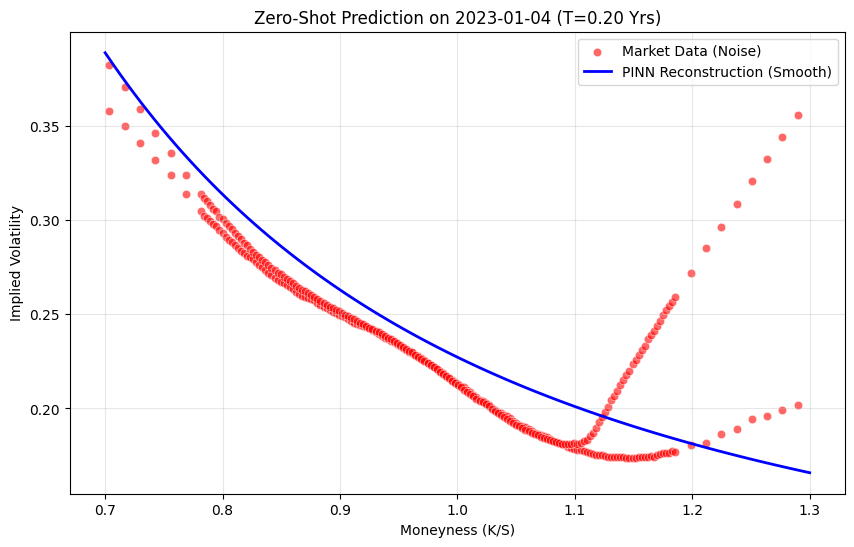


>>> Processing data for 2023-01-05...
Loaded 3638 valid samples for 2023-01-05. Spot=379.38
Result on 2023-01-05: RMSE=0.9346, MAPE=15.51%
Plotting Smile for 2023-01-05 (T=0.19)...


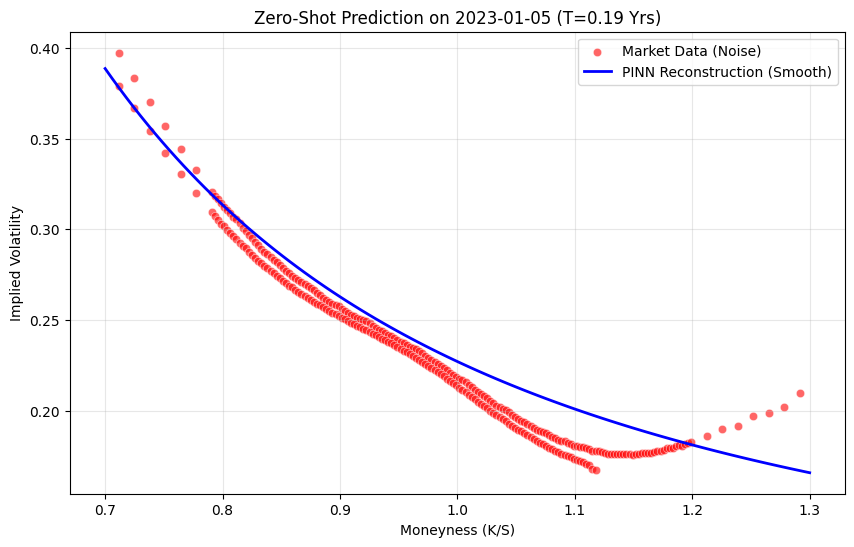


Zero-Shot Summary:
         Date      RMSE       MAPE
0  2023-01-04  1.495459  16.119030
1  2023-01-05  0.934613  15.505745


In [6]:
results_zero_shot = []

print("\n=== Experiment A: Zero-Shot Generalization ===")

for date in NEW_DATES:
    # 1. 获取数据
    df_test, loader, spot = get_data_loader_for_date(date)
    if df_test is None: continue
    
    # 2. 评估
    # 注意：这里用的是 base_model (未见过 1月4/5日的数据)
    metrics = calculate_metrics(base_model, loader, DEVICE)
    
    print(f"Result on {date}: RMSE={metrics['RMSE']:.4f}, MAPE={metrics['MAPE']:.2f}%")
    
    results_zero_shot.append({
        "Date": date,
        "RMSE": metrics['RMSE'],
        "MAPE": metrics['MAPE']
    })
    
    # 3. 画图验证 (看 Smile 是否偏移)
    # 选取中间的期限
    target_T = df_test['T'].median()
    print(f"Plotting Smile for {date} (T={target_T:.2f})...")
    try:
        plot_market_vs_model_smile(df_test, base_model, DEVICE, target_T, 
                                   title=f"Zero-Shot Prediction on {date}")
        plt.show()
    except Exception as e:
        print(f"Plotting error: {e}")

# 展示汇总结果
res_df = pd.DataFrame(results_zero_shot)
print("\nZero-Shot Summary:")
print(res_df)


=== Experiment B: Fast Fine-tuning (Transfer Learning) ===

Fine-tuning for 2023-01-04...

>>> Processing data for 2023-01-04...
Loaded 4075 valid samples for 2023-01-04. Spot=383.76
[Epoch 0001] train_loss=244.467017 price=3.424931 constraint=241.042086 | val_loss=2.420263 price=2.420251 constraint=0.000011
[Epoch 0010] train_loss=2.151077 price=2.151076 constraint=0.000002 | val_loss=2.147108 price=2.147096 constraint=0.000011
--- Summary for 2023-01-04 ---
Zero-Shot RMSE : 1.4955
Fine-Tuned RMSE: 1.4653
Improvement    : 0.0302


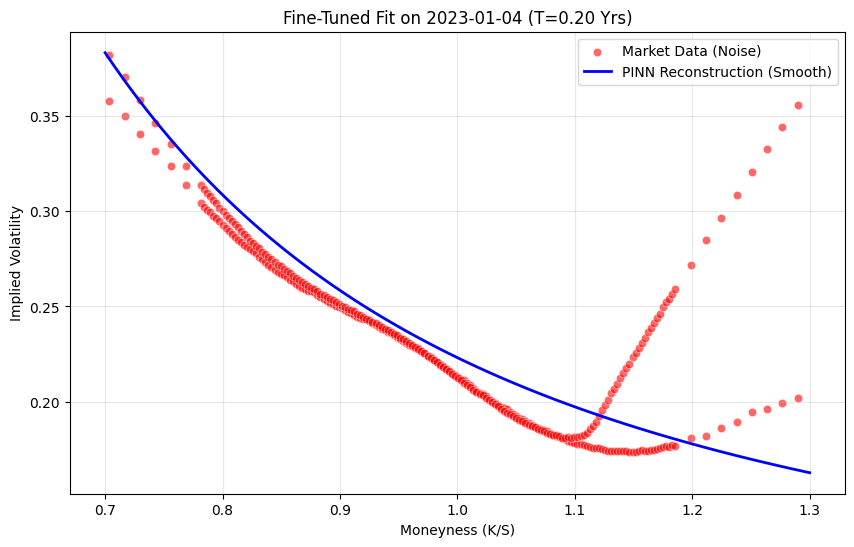


Fine-tuning for 2023-01-05...

>>> Processing data for 2023-01-05...
Loaded 3638 valid samples for 2023-01-05. Spot=379.38
[Epoch 0001] train_loss=321.689445 price=2.235549 constraint=319.453897 | val_loss=1.145612 price=1.145507 constraint=0.000105
[Epoch 0010] train_loss=0.762366 price=0.762364 constraint=0.000002 | val_loss=0.759046 price=0.759028 constraint=0.000018
--- Summary for 2023-01-05 ---
Zero-Shot RMSE : 0.9346
Fine-Tuned RMSE: 0.8712
Improvement    : 0.0634


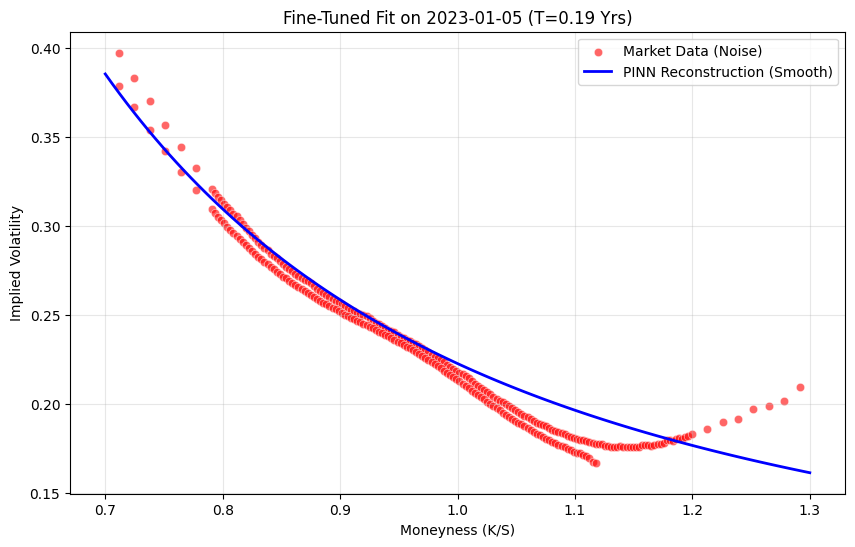

In [8]:
# Cell 5: 实验 B - 快速微调 (Transfer Learning)
# 修复版

print("\n=== Experiment B: Fast Fine-tuning (Transfer Learning) ===")

for date in NEW_DATES:
    print(f"\nFine-tuning for {date}...")
    
    # 1. 获取数据
    df_target, loader_target, _ = get_data_loader_for_date(date)
    if df_target is None: continue
    
    # 2. 克隆基础模型
    finetuned_model = copy.deepcopy(base_model)
    finetuned_model.train()
    
    # 3. 准备微调配置
    ft_config = TrainingConfig(
        epochs=10,           
        learning_rate=1e-4,  
        batch_size=256,
        lambda_calendar=1e-4, 
        lambda_butterfly=1e-4,
        input_cols=['log_moneyness', 'T'],
        target_col='mid_price'
    )
    
    # 4. 构建训练用的 Dataset
    train_ds = build_dataset_from_df(df_target, ft_config)
    
    # 5. 开始微调 (修复点：使用关键字参数)
    # -------------------------------------------------
    train(
        model=finetuned_model, 
        train_data=train_ds, 
        val_data=train_ds, 
        config=ft_config
    )
    # -------------------------------------------------
    
    # 6. 评估微调后的效果
    ft_metrics = calculate_metrics(finetuned_model, loader_target, DEVICE)
    
    # 7. 对比提升
    original_rmse = next((item['RMSE'] for item in results_zero_shot if item['Date'] == date), None)
    
    print(f"--- Summary for {date} ---")
    print(f"Zero-Shot RMSE : {original_rmse:.4f}")
    print(f"Fine-Tuned RMSE: {ft_metrics['RMSE']:.4f}")
    print(f"Improvement    : {original_rmse - ft_metrics['RMSE']:.4f}")
    
    # 8. 画微调后的图
    target_T = df_target['T'].median()
    try:
        plot_market_vs_model_smile(df_target, finetuned_model, DEVICE, target_T, 
                                   title=f"Fine-Tuned Fit on {date}")
        plt.show()
    except Exception as e:
        print(f"Plotting error: {e}")